** Pavel Smirnov @ github.com/pysmirnov **

Как-то так мы считаем характеристики резонансной кривой RLC-контура:

In [2]:
# масштабные коэффициенты
def freq_m(freq):
    freq *= 1e3; return freq;
def cap_m(cap):
    cap /= 1e9; return cap;

def inductance(freq,cap):
    return 1/(freq_m(freq)**2 * cap_m(cap))

def quality_factor(freq,cap,res):
    return 1/(freq_m(freq) * cap_m(cap) * res)

def reactive_res(freq,cap):
    return 1/(freq_m(freq)*cap_m(cap))

def resistance_ind(rho,q):
    return rho/q
                                         
def resistance_smax(rho):
    return rho*1e-3 # tan(1e-3) \approx 1e-3, да
                                         
def current(e_voltage,res_s):
    return e_voltage/res_s

def resistance_sum(r,r_s,r_l):
    return r+r_s+r_l
    #return (ind/cap_m(cap)*res_l) * sqrt( 1 + (res_l/(freq_m(freq)*ind)**2 ))

Теперь посмотрим, что же вышло в нашем контуре.

In [3]:
import numpy as np
import math

data = np.loadtxt('resonance_data.tsv', delimiter='\t')

R_L = []
L = []

out = open("resonance_results.tsv",'w')

for i in range(12):
    out.write("n\t C\t f\t U\t E\t L\t Q\t ρ\t R_Σ\t R_S\t R_L\t I\n")

for n in range(7):
    cap = data[n][0]
    freq = data[n][1]*2*math.pi
    u = data[n][2]
    e = data[n][3]
    r = 3.5 # Ohm
    
    ind = inductance(freq,cap)
    q = quality_factor(freq,cap,r)
    rho = reactive_res(freq,cap)
    r_s = resistance_smax(rho)
    r_l = resistance_ind(rho,q)
    r_sum = resistance_sum(r,r_s,r_l)
    i = current(e,r_s)
    
    R_L.append(r_l)
    L.append(ind)
    
    out.write(str(n+1)+'\t')
    for i in range(4):
        out.write(str(data[n][i])+'\t')
    # больной printf-like синтаксис...
    out.write("%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\n" % (ind*1e6,q,rho,r_sum,r_s,r_l,i*1e3))

out.close() 

print("R_L = {0:.1f} Ом".format(np.average(R_L)))
print("L = {0:.1f} мкГН".format(np.average(L)*1e6))

R_L = 3.5 Ом
L = 979.1 мкГН


Построим АЧХ для двух контуров:

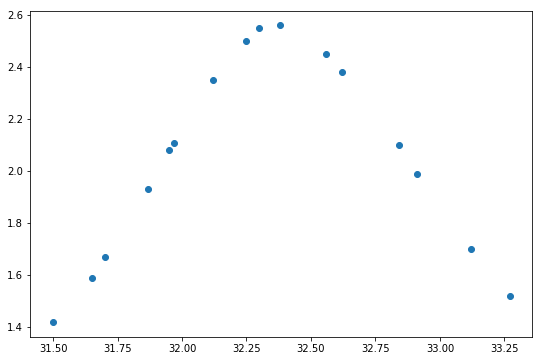

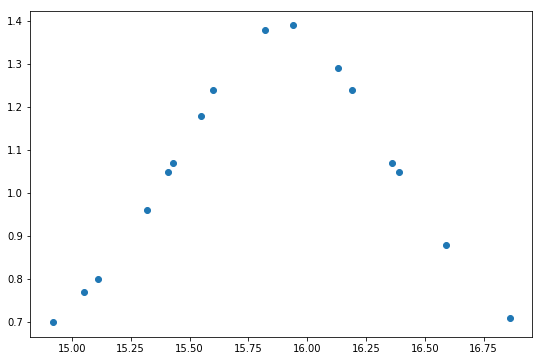

In [59]:
data = []
data = np.loadtxt('freq_response.tsv', delimiter='\t')

import matplotlib.pyplot as plt

plt.plot(data[:,0],data[:,1],'o')
#plt.savefig("freq_response_c1.svg", format="svg")
plt.show()

plt.plot(data[:,2],data[:,3],'o')
#plt.savefig("freq_response_c2.svg", format="svg")
plt.show()


Кубическая интерполяция! Нужен ли здесь сплайн?..

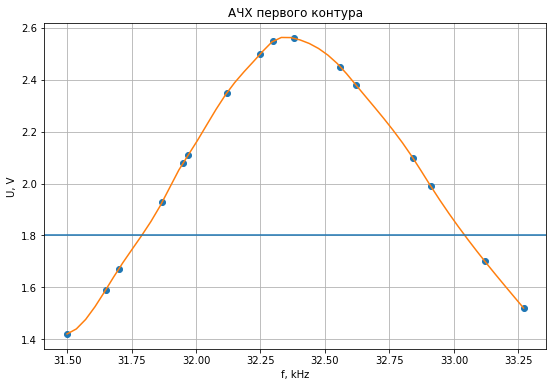

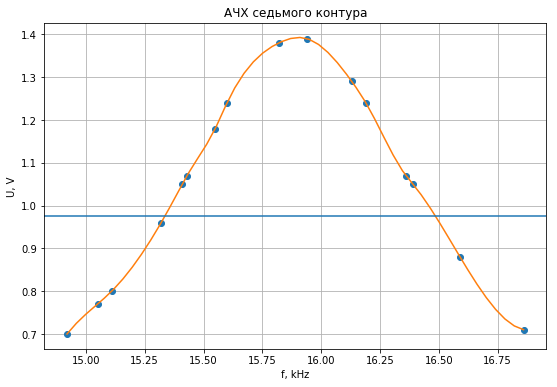

In [56]:
from scipy.interpolate import interp1d
import pylab

pylab.rcParams['figure.figsize'] = (9.0, 6.0)

def pltinp(x,y, lbl):
    # f = interp1d(x, y)
    f2 = interp1d(x, y, kind='cubic')
    
    xnew = np.linspace(np.min(x),np.max(x),50)

    plt.plot(x, y, 'o')
    plt.plot(xnew, f2(xnew), label = lbl)
    #print(xnew)
    #print(f2(xnew))

def freq_res_legend():
    pylab.legend(loc='upper left')
    plt.xlabel('f, kHz')
    plt.ylabel('U, V')
    plt.grid(True)
    plt.legend()

pltinp(data[:,0],data[:,1],'')
plt.axhline(data[0,1]/math.sqrt(2))
freq_res_legend()
plt.title('АЧХ первого контура')
plt.savefig("freq_response_c1.svg", format="svg")
plt.show()

pltinp(data[:,2],data[:,3],'')
plt.axhline(data[0,3]/math.sqrt(2))
freq_res_legend()
plt.title('АЧХ седьмого контура')
plt.savefig("freq_response_c7.svg", format="svg")
plt.show()

Теперь построим АЧХ на одном графике в безразмерных координатах, дабы сравнить их.

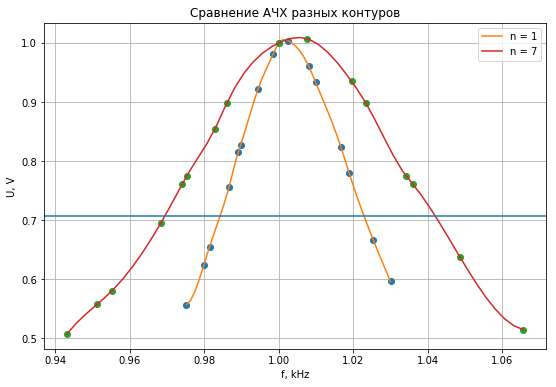

In [64]:
pltinp(data[:,0]/data[0,0],data[:,1]/data[0,1],'n = 1')
pltinp(data[:,2]/data[0,2],data[:,3]/data[0,3],'n = 7')

plt.axhline(1/math.sqrt(2))
freq_res_legend()
plt.title('Сравнение АЧХ разных контуров')

plt.savefig("freq_response_compar.svg", format="svg")
plt.show()

Теперь ФЧХ:

[[  1.06646059   1.25        -2.4          0.99496222 -10.          -0.4       ]
 [  1.05069552   1.25        -2.4          1.00314861  -9.          -0.4       ]
 [  1.02627512   1.20833333  -2.4          1.02329975  -5.6         -0.5       ]
 [  1.00401855   1.04347826  -2.3          1.10453401  -1.77777778  -0.9       ]
 [  1.01267388   1.13043478  -2.3          1.06612091  -2.85714286  -0.7       ]
 [  1.03956723   1.25        -2.4          1.03652393  -4.          -0.6       ]
 [  1.06244204   1.25        -2.4          1.09256927  -2.          -0.9       ]
 [  0.9820711    0.72727273  -2.2          0.9697733   -7.33333333  -0.6       ]
 [  0.94714065   0.66666667  -2.1          0.88413098  -0.875       -1.6       ]
 [  0.91653787   0.7         -2.           0.90554156  -0.8         -2.        ]
 [  0.93353941   0.66666667  -2.1          0.92947103  -0.7         -2.        ]
 [  0.95826893   0.59090909  -2.2          0.94710327  -0.85        -2.        ]
 [  0.974034     0.66666667 

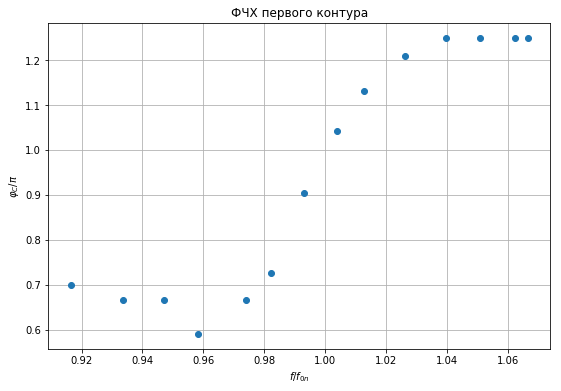

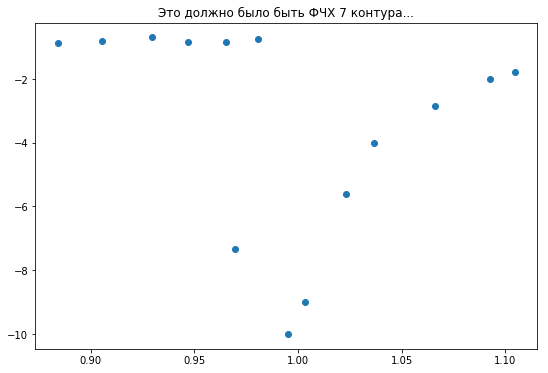

In [65]:
data = []
data = np.loadtxt('phase_response.tsv', delimiter='\t')

def phase(x,x_0):
    return (x/x_0)*math.pi

def phase_res_legend():
    pylab.legend(loc='upper left')
    plt.xlabel(r'$f/f_{0n}$')
    plt.ylabel(r'$\varphi_C / \pi$')
    plt.grid(True)
    plt.legend()

for i in range(14):
    data[i,1] = phase(data[i,1],data[i,2])/math.pi*(-1)
    data[i,4] = phase(data[i,4],data[i,5])/math.pi*(-1)
    data[i,0] /= 32.35
    data[i,3] /= 15.88
    
print(data)

#pltinp(data[:,0],data[:,1],u'ФЧХ для n=1')
phase_res_legend()
plt.title('ФЧХ первого контура')
plt.plot(data[:,0],data[:,1],'o')
plt.savefig("phase_response_c1.svg", format="svg")
plt.show()

plt.title('Это должно было быть ФЧХ 7 контура...')
plt.plot(data[:,3],data[:,4],'o',label = 'Это ужасно!')
plt.show()


Для первого контура все еще неплохо, хотя фиттинг, конечно, мы делать не будем.
А вот **второй контур улетает из нашей работы**. В чем была криворукость, когда данные записывались?